## Unsupervided Learning Trding Strategy
- Download SP500 stocks prices data
- Calculate different feature and indicators on each stock
- Aggregate on monthly level and file¿ter top 150 most liquid stocks
- calculate Monthly Returns for different time - horizons
- Download Fama-French Factors and Calculate Factor Betas
- For each month fit a K-Means Clustering Algorithm to group asset based on their features
- For each month select asset based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
- Visualize Portofolio returns and compare to SP500 returns


### 1. Download SP500 prices data

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [2]:
sp500 =  pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500.head(500)

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
495,WTW,Willis Towers Watson,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536,2016
496,WYNN,Wynn Resorts,Consumer Discretionary,Casinos & Gaming,"Paradise, Nevada",2008-11-14,1174922,2002
497,XEL,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011


In [3]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

In [4]:
symbols_list = sp500['Symbol'].unique().tolist()

In [5]:
end_data= '2023-09-27'
start_data = pd.to_datetime(end_data) - pd.DateOffset(365*8)

df_sp500 = yf.download(tickers=symbols_list,
                 start=start_data,
                 end=end_data)

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['GEV', 'SOLV', 'VLTO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


In [6]:
df = df_sp500.copy()

In [7]:
df = df.stack()
df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-09-29 A        31.425232   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651134   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334911   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   Volume  
Date       Ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[987967 rows x 6 columns]

In [8]:
df.index.names = ['date','ticker']

In [9]:
df.columns = df.columns.str.lower()
df.head(5)

Price              adj close      close       high        low       open  \
date       ticker                                                          
2015-09-29 A       31.425232  33.740002  34.060001  33.240002  33.360001   
           AAL     37.361618  39.180000  39.770000  38.790001  39.049999   
           AAPL    24.651134  27.264999  28.377501  26.965000  28.207500   
           ABBV    36.334911  52.790001  54.189999  51.880001  53.099998   
           ABT     33.478706  39.500000  40.150002  39.029999  39.259998   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0

## 2. Calculate features and technical indicators for each stock

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR 
- MACD
- Dollar Volume

### - Garnan-Klass Volatilily

In [10]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)- 1) * (np.log(df['adj close'])- np.log(df['open']))**2

In [11]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x : pandas_ta.rsi(close=x, length=20))


<Axes: xlabel='date'>

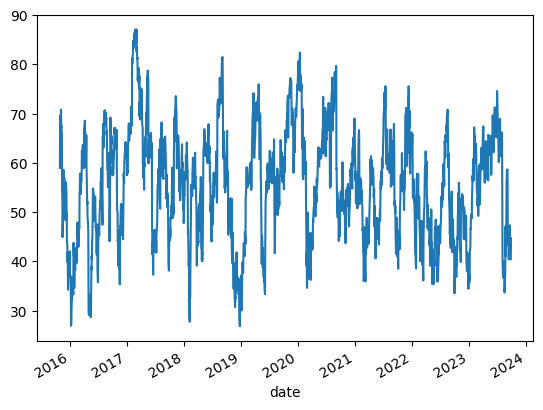

In [12]:
df.xs('AAPL',level=1)['rsi'].plot()

### Bollinger Bands

In [13]:
pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
date,,,,,
2015-09-29,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN
2015-10-01,NaN,NaN,NaN,NaN,NaN
2015-10-02,NaN,NaN,NaN,NaN,NaN
2015-10-05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-09-20,169.990815,179.634540,189.278264,10.737049,0.249273
2023-09-21,169.249735,179.276455,189.303174,11.185763,0.199221
2023-09-22,169.034260,179.197268,189.360276,11.342816,0.249295


In [14]:
df.groupby(level=1)['adj close'].apply(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20)).iloc[:,0]

ticker  date        ticker
A       2015-09-29  A              NaN
        2015-09-30  A              NaN
        2015-10-01  A              NaN
        2015-10-02  A              NaN
        2015-10-05  A              NaN
                                ...   
ZTS     2023-09-20  ZTS       5.177897
        2023-09-21  ZTS       5.170765
        2023-09-22  ZTS       5.165861
        2023-09-25  ZTS       5.161777
        2023-09-26  ZTS       5.156108
Name: BBL_20_2.0, Length: 987967, dtype: float64

In [15]:
# Paso 1: Calcular las Bandas de Bollinger para cada grupo
bbands = df.groupby(level=1)['adj close'].apply(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20))

# Paso 2: Convertir el multiíndice resultante en columnas normales
bbands = bbands.reset_index(level=0, drop=True)

# Paso 3: Extraer las bandas baja, media y alta
df['bb_low'] = bbands['BBL_20_2.0']
df['bb_mid'] = bbands['BBM_20_2.0']
df['bb_high'] = bbands['BBU_20_2.0']


In [16]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425232   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651134   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334911   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146737  4.485761   
           YUM       1500600.0         -0.000051  36.057206  4.811707   
           ZBH       3610500.0          0.000022  31.893258  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623467  5.156108   

Price                bb_mid   bb_high  
date       ticker                      
2015-09-29 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2023-09-26 XYL     4.567684  4.649607  
           YUM     4.841672  4.871637  
           ZBH     4.785551  4.825217  
           ZBRA    5.539167  5.677342  
           ZTS     5.214922  5.273735  

[987967 rows x 11 columns]

### ATR

In [21]:
def compute_atr(stock_data):
    atr =pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], lenght=14)
    return atr.sub(atr.mean()).div(atr.std())

In [22]:
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425232   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651134   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334911   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478706   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146737  4.485761   
           YUM       1500600.0         -0.000051  36.057206  4.811707   
           ZBH       3610500.0          0.000022  31.893258  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623467  5.156108   

Price                bb_mid   bb_high      macd       atr  
date       ticker                                          
2015-09-29 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2023-09-26 XYL     4.567684  4.649607 -2.159189  0.033800  
           YUM     4.841672  4.871637 -1.363696  0.142547  
           ZBH     4.785551  4.825217 -0.881067 -0.381708  
           ZBRA    5.539167  5.677342 -1.600791 -0.057389  
           ZTS     5.214922  5.273735 -1.188279  0.651515  

[987967 rows x 13 columns]

In [20]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, lenght=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

In [23]:
df['dollar_volumen']= (df['adj close'] * df['volume'])/1e6

In [24]:
df.head()

Price              adj close      close       high        low       open  \
date       ticker                                                          
2015-09-29 A       31.425232  33.740002  34.060001  33.240002  33.360001   
           AAL     37.361618  39.180000  39.770000  38.790001  39.049999   
           AAPL    24.651134  27.264999  28.377501  26.965000  28.207500   
           ABBV    36.334911  52.790001  54.189999  51.880001  53.099998   
           ABT     33.478706  39.500000  40.150002  39.029999  39.259998   

Price                   volume  garman_klass_vol  rsi  bb_low  bb_mid  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082  NaN     NaN     NaN   
           AAL       7478800.0         -0.000443  NaN     NaN     NaN   
           AAPL    293461600.0         -0.005712  NaN     NaN     NaN   
           ABBV     12842800.0         -0.054655  NaN     NaN     NaN   
           ABT      12287500.0         -0.009402  NaN     NaN     NaN   

Price              bb_high  macd  atr  dollar_volumen  
date       ticker                                      
2015-09-29 A           NaN   NaN  NaN       70.782192  
           AAL         NaN   NaN  NaN      279.420069  
           AAPL        NaN   NaN  NaN     7234.161370  
           ABBV        NaN   NaN  NaN      466.641999  
           ABT         NaN   NaN  NaN      411.369604

### 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month

In [29]:
last_cols = [ c for c in df.columns.unique(0) if c not in ['dollar_volumen','volume','open','high','low','close']]
last_cols

#df.unstack('ticker')['dollar_volumen'].resample('M').mean()

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'macd',
 'atr']

In [35]:
data = pd.concat([df.unstack('ticker')['dollar_volumen'].resample('M').mean().stack('ticker').to_frame("dollar_volumen")  ,df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1).dropna()
data

dollar_volumen   adj close  garman_klass_vol        rsi  \
date       ticker                                                            
2015-11-30 A           135.740913   38.950901         -0.002098  73.421489   
           AAL         287.915796   39.429935         -0.000966  40.719007   
           AAPL       4023.983766   26.854139         -0.003307  55.537390   
           ABBV        337.563907   40.393532         -0.059549  49.376873   
           ABT         211.659041   38.293571         -0.011216  56.962617   
...                           ...         ...               ...        ...   
2023-09-30 OTIS        154.361755   78.356506         -0.000097  33.116289   
           ABNB       1633.500725  132.279999          0.000213  44.494127   
           CEG         196.670368  107.862030          0.000131  55.245485   
           GEHC        212.275850   66.130219          0.000185  40.922337   
           KVUE        670.804320   20.006195         -0.000159  35.706315   

                     bb_low    bb_mid   bb_high      macd       atr  
date       ticker                                                    
2015-11-30 A       3.544191  3.616636  3.689081  0.567157 -1.033887  
           AAL     3.672028  3.749832  3.827636 -0.418771  0.190822  
           AAPL    3.281679  3.324990  3.368302 -0.142790 -0.967900  
           ABBV    3.726695  3.774943  3.823191  0.145677 -0.526809  
           ABT     3.656055  3.677909  3.699763  0.335558 -1.064842  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.370137  4.415425  4.460712 -1.534535 -1.028320  
           ABNB    4.857047  4.940924  5.024801 -0.037854 -1.006939  
           CEG     4.652147  4.692320  4.732493  0.366876 -0.436215  
           GEHC    4.155436  4.212972  4.270508 -1.116463 -0.893478  
           KVUE    3.014275  3.089221  3.164168 -1.435620 -0.899746  

[46648 rows x 9 columns]

In [38]:
data['dollar_volumen'] =  (data['dollar_volumen'].unstack('ticker').rolling(5*12).mean().stack())
data

dollar_volumen   adj close  garman_klass_vol        rsi  \
date       ticker                                                            
2015-11-30 A                  NaN   38.950901         -0.002098  73.421489   
           AAL                NaN   39.429935         -0.000966  40.719007   
           AAPL               NaN   26.854139         -0.003307  55.537390   
           ABBV               NaN   40.393532         -0.059549  49.376873   
           ABT                NaN   38.293571         -0.011216  56.962617   
...                           ...         ...               ...        ...   
2023-09-30 OTIS               NaN   78.356506         -0.000097  33.116289   
           ABNB               NaN  132.279999          0.000213  44.494127   
           CEG                NaN  107.862030          0.000131  55.245485   
           GEHC               NaN   66.130219          0.000185  40.922337   
           KVUE               NaN   20.006195         -0.000159  35.706315   

                     bb_low    bb_mid   bb_high      macd       atr  
date       ticker                                                    
2015-11-30 A       3.544191  3.616636  3.689081  0.567157 -1.033887  
           AAL     3.672028  3.749832  3.827636 -0.418771  0.190822  
           AAPL    3.281679  3.324990  3.368302 -0.142790 -0.967900  
           ABBV    3.726695  3.774943  3.823191  0.145677 -0.526809  
           ABT     3.656055  3.677909  3.699763  0.335558 -1.064842  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.370137  4.415425  4.460712 -1.534535 -1.028320  
           ABNB    4.857047  4.940924  5.024801 -0.037854 -1.006939  
           CEG     4.652147  4.692320  4.732493  0.366876 -0.436215  
           GEHC    4.155436  4.212972  4.270508 -1.116463 -0.893478  
           KVUE    3.014275  3.089221  3.164168 -1.435620 -0.899746  

[46648 rows x 9 columns]

In [41]:
data['dollar_vol_rank'] = data.groupby('date')['dollar_volumen'].rank(ascending=False)
data = data[data['dollar_vol_rank']<150].drop(['dollar_volumen','dollar_vol_rank'], axis=1)